In [2]:
import tensorflow as tf
import os
import time

import numpy as np
import pandas as pd
import scipy.io  # load the matrix file
import pickle as cp

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split

from tensorflow.contrib import rnn
from tensorflow.python.framework import ops

from sliding_window import sliding_window

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sklearn.metrics as metrics

## 1. Reading Opportunity Dataset

In [4]:
def load_dataset(filename):
    """
    Function to load dataset

    Argument:
        filename : the path of the preprocessed dataset

    Return:

        X_train
        y_train
        X_test
        y_test

    Notice:
        Need use `pickle(python3)` or`cpicckle(python2)` module to load and read dataset.


    """

    f = open(filename, 'rb')
    data = cp.load(f)
    f.close()

    X_train, y_train = data[0]
    X_test, y_test = data[1]

    print(" ..from file {}".format(filename))
    print(" ..reading instances: X_train {0}, X_test {1}".format(
        X_train.shape, X_test.shape))
    print(" ..reading instances: y_train {0}, y_test {1}".format(
        y_train.shape, y_test.shape))

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # The targets are casted to int8 for GPU compatibility.
    y_train = y_train.astype(np.uint8)
    y_test = y_test.astype(np.uint8)

    return X_train, y_train, X_test, y_test


print("Loading data...")
# X_train, y_train, X_test, y_test = load_dataset('DeepConvLSTM/data/gestures_wearable_ambient.data')
X_train, y_train, X_test, y_test = load_dataset('C:/Users/41762/Dropbox/Dataset/Opportunity/gestures_wearable_ambient.data')
# /Users/chentailin/sharedfolder/Human-Activity-Recognition-CodeHub/opportinity-dataset/DeepConvLSTM/data/gestures_wearable_ambient.data

X_train_origin = X_train.copy()
y_train_origin = y_train.copy()
X_test_origin, y_test_origin = X_test.copy(), y_test.copy()

print("Successfully")

print("---" * 20)

# Normalization the Raw data


def normalization_x_y(x, y):
    """
    Stack x and y, then do normalization
    Then return DataFrame x and y
    """
    print("Data normalizing...")
    data = np.vstack((x, y))
    df = pd.DataFrame(data)
    df = (df - df.min()) / (df.max() - df.min())

    data_x = df.iloc[:557963, ]
    data_y = df.iloc[557963:, ]

    data_x = np.array(data_x)
    data_y = np.array(data_y)

    print("Data normalized...")
    return data_x, data_y


# Normalization the whole dataset
X_train_nor, X_test_nor = normalization_x_y(X_train, X_test)


# split the wearable sensor data and ambient sensor data
print("---" * 20)
print("Spliting the data into F & A... ")
X_train_F = X_train_nor[:, :113]
X_train_A = X_train_nor[:, 113:]

X_test_F = X_test_nor[:, :113]
X_test_A = X_test_nor[:, 113:]

# More clearly split
F_train = X_train_F
F_test = X_test_F

A_train = X_train_A
A_test = X_test_A
print("Successfully")

print("---" * 20)
print("{0} actual activities and 1 NaN activity,\nTotal 18 Classes".format(y_train.max()))

# Opportunity num_classes = 18
num_classes = 18

print("F_train shape is ", F_train.shape)
print("F_test shape is ", F_test.shape)

print("A_train shape is ", A_train.shape)
print("A_test shape is ", A_test.shape)


print("y_train shape is ", y_train.shape)
print("y_test shape is ", y_test.shape)

print("---" * 20)

print("Opperating sliding window...")
"""
Define Sliding Window
"""
SLIDING_WINDOW_LENGTH = 24
SLIDING_WINDOW_STEP = 12

# from sliding_window import sliding_window
# ?sliding_window

# assert NB_SENSOR_CHANNELS == X_train.shape[1]


def opp_sliding_window(data_x, data_a, data_y, ws, ss):
    """
   Parameters: (F_train,A_train,y_train,window_size,step_size)

    """
    data_x = sliding_window(a=data_x, ws=(
        ws, data_x.shape[1]), ss=(ss, 1), flatten=False)
#     data_x = sliding_window(data_x,ws,ss)
    data_a = sliding_window(a=data_a, ws=(
        ws, data_a.shape[1]), ss=(ss, 1), flatten=False)
    data_y = np.asarray([[i[-1]]
                         for i in sliding_window(data_y, ws, ss, flatten=False)])
    return data_x.reshape(-1, ws, data_x.shape[3]).astype(np.float32), data_a.reshape(-1, ws, data_a.shape[3]).astype(np.float32), data_y.reshape(-1).astype(np.uint8)
#     return data_x.astype(np.float32), data_y.flatten().astype(np.uint8)


F_train0, A_train0, y_train0 = opp_sliding_window(
    F_train, A_train, y_train, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
print(" ..after sliding window (training):\n inputs : (wearable sensor data) F_train0{0} , (ambient sensor data) A_train0{1}, targets(label) y_train0 {2}".format(
    F_train0.shape, A_train0.shape, y_train0.shape))

F_test0, A_test0, y_test0 = opp_sliding_window(
    F_test, A_test, y_test, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
print(" ..after sliding window (testing):\n inputs : (wearable sensor data) F_test0{0} , (ambient sensor data) A_test0{1}, targets(label) y_test0 {2}".format(
    F_test0.shape, A_test0.shape, y_test0.shape))

print("Successfully")
print("---" * 20)


print("Changing targets shape... (One-Hot Encoder for cross-entropy loss ) ")
y_train1 = to_categorical(y=y_train0, num_classes=num_classes)
y_test1 = to_categorical(y=y_test0, num_classes=num_classes)
print("Before transforming: y_train0 shape {0}, y_test0 shape {2} \nAfter transforming: y_train1 shape {1},y_test1 shape {3}".format(
    y_train0.shape, y_train1.shape, y_test0.shape, y_test1.shape))

print("Successfully")

print("---" * 20)
X_train = np.reshape(
    F_train0, (F_train0.shape[0], F_train0.shape[1], F_train0.shape[2], 1))  # reshape末尾增加1维
X_valid = np.reshape(
    F_test0, (F_test0.shape[0], F_test0.shape[1], F_test0.shape[2], 1))
y_train = y_train1
y_valid = y_test1


print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print('y_train.shape' + str(y_train.shape))
print('y_train.shape' + str(y_train.shape))

print("Reshape the X_train and X_valid for CNN input")
X_train_cnn = np.swapaxes(X_train, 1, 2)  # 就是将第三个维度和第二个维度交换
X_valid_cnn = np.swapaxes(X_valid, 1, 2)

print("X_train_cnn shape", X_train_cnn.shape)
print("X_valid_cnn shape", X_valid_cnn.shape)
print('X_train.shape' + str(y_train.shape))
print('y_train.shape' + str(y_train.shape))

Loading data...
 ..from file C:/Users/41762/Dropbox/Dataset/Opportunity/gestures_wearable_ambient.data
 ..reading instances: X_train (557963, 210), X_test (118750, 210)
 ..reading instances: y_train (557963,), y_test (118750,)
Successfully
------------------------------------------------------------
Data normalizing...
Data normalized...
------------------------------------------------------------
Spliting the data into F & A... 
Successfully
------------------------------------------------------------
17 actual activities and 1 NaN activity,
Total 18 Classes
F_train shape is  (557963, 113)
F_test shape is  (118750, 113)
A_train shape is  (557963, 97)
A_test shape is  (118750, 97)
y_train shape is  (557963,)
y_test shape is  (118750,)
------------------------------------------------------------
Opperating sliding window...
 ..after sliding window (training):
 inputs : (wearable sensor data) F_train0(46495, 24, 113) , (ambient sensor data) A_train0(46495, 24, 97), targets(label) y_train


## Now, all the data are prepared to be input into the Deep Model

- ` F_train0 ` ------> ` y_train1 ` <------` A_train0 `

- ` F_test0 ` ------>   ` y_test1 ` <------` A_test0 `

--- 

## 2. Building TensorFlow Model

Because we noly choose **F** as the feature and **y** as the label
- Let 
        X_train =F_train0
        X_test = F_test0
        y_train = y_train1
        y_test = y_test1

In [5]:
F_train0.shape
F_test0.shape

(9894, 24, 113)

In [6]:
X_train = np.reshape(F_train0,(F_train0.shape[0],F_train0.shape[1],F_train0.shape[2],1)) # reshape末尾增加1维
X_valid = np.reshape(F_test0,(F_test0.shape[0],F_test0.shape[1],F_test0.shape[2],1))
y_train = y_train1
y_valid = y_test1


print("X_train shape" , X_train.shape)
print("X_valid shape" , X_valid.shape)


X_train shape (46495, 24, 113, 1)
X_valid shape (9894, 24, 113, 1)


In [7]:
print('X_train.shape' + str(X_train.shape))
print('Y_train.shape' + str(y_train.shape))

X_train.shape(46495, 24, 113, 1)
Y_train.shape(46495, 18)


**Define the model**

# 2. Define the `ConvLstm` Model

In [8]:
def model_variant(model, num_feat_map, dim, network_type):
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) # for swap-dimension
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(LSTM(32, return_sequences=False, stateful=False))
        model.add(Dropout(0.2))
    if network_type == 'CNN':
         
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))

def model_conv(model, num_feat_map):
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_feat_map, 
                     kernel_size=(1, 5), 
                     activation='relu',
                     padding='same'))
    
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.2))
     

def model_LSTM(model):
    model.add(LSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(0.2))

# def model_LSTM(model):
    

# ### def model_MLP(model, num_hidden_mlp):
#     model.add(Dense(num_hidden_mlp, activation='relu', input_shape=(dim*win_len,)))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_hidden_mlp, activation='relu'))
#     model.add(Dropout(0.5))

def model_output(model):
    model.add(Dense(num_classes, activation='softmax'))

In [9]:
batch_size = 128
num_feat_map = 16
num_hidden_mlp = 128
num_hidden_lstm = 64



In [10]:
network_type = 'ConvLSTM'

In [11]:
X_train.shape

(46495, 24, 113, 1)

In [12]:

_, win_len, dim,nc= X_train.shape


In [13]:
X_train_cnn.shape

(46495, 113, 24, 1)

In [14]:
model = Sequential()

In [15]:
if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map)
    model_variant(model, num_feat_map, dim, network_type)
if network_type=='LSTM':
    model_LSTM(model)
if network_type=='MLP': 
    model_MLP(model, num_hidden_mlp) 
    

ConvLSTM


In [16]:
print(X_train_cnn.shape)
model_output(model)    
model.summary()

(46495, 113, 24, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 113, 24, 16)       96        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 113, 12, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 113, 12, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 113, 12, 16)       1296      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 113, 6, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 113, 6, 16)        0         
_________________________________________________________________
permute_1 (Permute)          (None, 6, 113, 16)        0

# 3. Compile the model
- Chose `F1-Score` and `Cross-entropy Loss` and `Confusion Matrix` as the metrics

In [17]:
from keras import metrics

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

tensorboardCallBack = TensorBoard(log_dir='./Opportunity-Graph', histogram_freq=0, write_graph=True, write_images=True)

print(X_test.shape)
print(y_test.shape)

(118750, 210)
(118750,)


In [19]:
epochs =20
H = model.fit(X_train_cnn, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=False,
            validation_data=(X_valid_cnn, y_valid),
#             callbacks=[tensorboardCallBack]
             )

Train on 46495 samples, validate on 9894 samples
Epoch 1/20
46495/46495 [==============================] - 15s 330us/step - loss: 1.4807 - acc: 0.6919 - val_loss: 0.9087 - val_acc: 0.8325
Epoch 2/20
46495/46495 [==============================] - 10s 217us/step - loss: 1.4912 - acc: 0.6955 - val_loss: 0.9116 - val_acc: 0.8325
Epoch 3/20
46495/46495 [==============================] - 10s 218us/step - loss: 1.4843 - acc: 0.6957 - val_loss: 0.9122 - val_acc: 0.8325
Epoch 4/20
46495/46495 [==============================] - 10s 219us/step - loss: 1.4817 - acc: 0.6957 - val_loss: 0.9135 - val_acc: 0.8325
Epoch 5/20
46495/46495 [==============================] - 10s 220us/step - loss: 1.4784 - acc: 0.6957 - val_loss: 0.9138 - val_acc: 0.8325
Epoch 6/20
46495/46495 [==============================] - 10s 217us/step - loss: 1.4760 - acc: 0.6957 - val_loss: 0.9139 - val_acc: 0.8325
Epoch 7/20
46495/46495 [==============================] - 10s 217us/step - loss: 1.4724 - acc: 0.6957 - val_loss: 0.9

# 5. `f1-score` and `confusion matrix`
macro
- 0.5139
- 0.5063
- 0.4933
- 0.4555
- 0.4817
- 0.4761
- 0.5047
- 0.5328
- 0.5356
- 0.5566
- 0.5643

In [21]:
foo = model.predict_classes(X_valid_)

ValueError: Error when checking input: expected conv2d_1_input to have 4 dimensions, but got array with shape (118750, 210)

In [20]:
# Results presentation
import time
start_time = time.time()

print("||Results||")


import sklearn.metrics as metrics


print("\tTest f1 score(macro):\t{:.4f} ".format(metrics.f1_score(y_true=y_test0, y_pred=foo,average="macro")))
print("\tTest f1 score(weighted):\t{:.4f} ".format(metrics.f1_score(y_true=y_test0, y_pred=foo,average="weighted")))

# print("\tTest confusion matrix:\t{:} ".format(metrics.confusion_matrix(y_test0, y_pred=foo)))
# print("\tTest fscore:\t{:} ".format(metrics.(y_test0, y_pred=foo)))

print("\tTook {:.3f}s.".format( time.time() - start_time))


||Results||


NameError: name 'foo' is not defined

## 6. plot the confusion matrix

http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

Confusion matrix, without normalization
[[8155    0    0    0   39    0    0    0    0    0    0    0    0    0
     0    0   43    0]
 [  32    0    0    0   26    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  47    0    0    0   48    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  31    0    0    0   29    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  26    0    0    0   57    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [ 228    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [ 160    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [ 100    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  77    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  39    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  42    

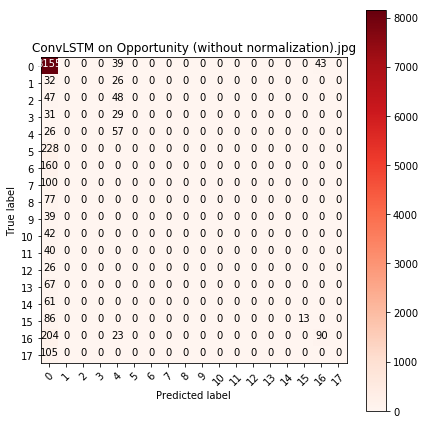

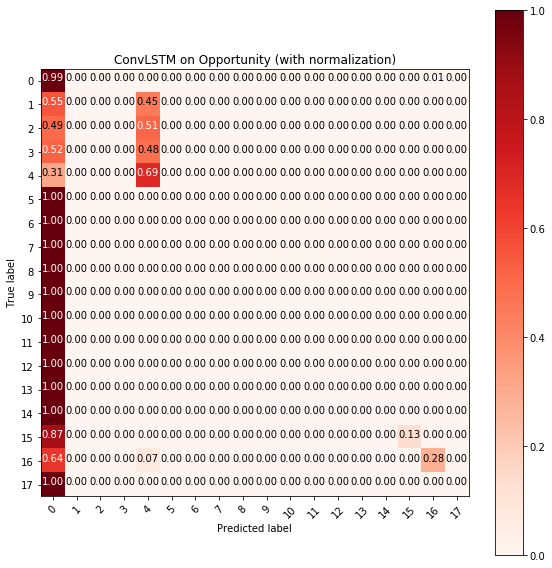

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('int') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test0, foo)
np.set_printoptions(precision=3)


# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix,classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],
                      title='ConvLSTM on Opportunity (without normalization).jpg')
plt.savefig("ConvLSTM on Opportunity (without normalization).jpg")

#Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], normalize=True,
#                        title='Normalized confusion matrix')
                      title='ConvLSTM on Opportunity (with normalization)')
plt.savefig("ConvLSTM on Opportunity (with normalization).jpg")
plt.show()